In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import xarray as xr
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import dataframe_image as dfi
import sys
sys.path.insert(0, '/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability')
import tool_box

colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

def cf_profile_finder(cf_prof_maps):
    cf_prof_maps_ = np.sort(cf_prof_maps)
    profile_cf = np.array([np.load(cf_prof_maps_[yr])[0] for yr in range(len(cf_prof_maps_))])
    empty_prof_map = np.empty(np.shape(profile_cf[:5]))
    empty_prof_map[:] = np.NaN
    profile_cf = np.concatenate((empty_prof_map, profile_cf), axis=0)
    profile_cf = np.reshape(profile_cf, (16,12,36,221))
    profile_cf[10,1] = np.nanmean([profile_cf[10,0], profile_cf[10,2]], axis=0)
    profile_cf_anoms = profile_cf - np.nanmean(profile_cf, axis=0)
    return(profile_cf_anoms)

# Pull in timeseries
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'
cpts, cpzs, total_cf, temp_profs, profiles_cf, allTCFCalendarMaps, mjo_index, enso_index, qbo_index, bdc_mf, bdc_eddy, wv_calendar = tool_box.starter()

# Pull in other CF data
all_cf_prof_maps = np.sort(glob.glob(project_path + '/aerosol_cloud_distinctions/cfmaps/GlobalZMMonthlyCFProfiles_strataerosolremoved_polarcloudsremoved_*.npy'))
profile_all_cf_anoms = cf_profile_finder(all_cf_prof_maps)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:72: RuntimeWarning: All-NaN slice encountered
  cold_point_temps = np.nanmin(temp_prof, axis=4)
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [2]:
# Get annual mean tropopause data
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'
cpz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/cpz_maps_zm_annual_mean.npy')
lrz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/lrz_maps_zm_annual_mean.npy')

# Water vapor data needs to be re-binned
wv_cal_anoms = wv_calendar - np.nanmean(wv_calendar, axis=0)
wv_cal_anoms_ts = np.reshape(wv_cal_anoms, (17*12,55,45))[12:]
h2o_anoms_zm_ts = np.swapaxes(wv_cal_anoms_ts, 1, 2)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [31]:
def vert_temp_gradient(data_calendar):
    data_calendar = np.array(data_calendar)
    t_1 = data_calendar[:,:,1:]
    t_2 = data_calendar[:,:,:-1]
    dt_dz = (t_1 - t_2)/0.1 # K/km
    dt_dz_1 = dt_dz[:,:,1:]
    dt_dz_2 = dt_dz[:,:,:-1]
    dt_dz_new = np.nanmean([dt_dz_1, dt_dz_2], axis=0)
    empty = np.empty(np.shape(data_calendar[:,:,0]))
    empty[:] = np.NaN
    dt_dz_new = np.insert(dt_dz_new, 348, empty, axis=2)
    dt_dz_new = np.insert(dt_dz_new, 0, empty, axis=2)
    smoothed_dtdz_cal = []
    for mon in range(len(dt_dz_new)):
        global_smoothed = []
        for lat in range(len(dt_dz_new[0,:])):
            data = dt_dz_new[mon,lat]
            rolling_mean = pd.Series(data).rolling(10).mean()
            global_smoothed.append(rolling_mean)
        smoothed_dtdz_cal.append(global_smoothed)
    return(np.array(smoothed_dtdz_cal))

RO_monthly_mean_maps = np.nanmean(temp_profs, axis=3)
RO_anomaly_maps = RO_monthly_mean_maps - np.nanmean(RO_monthly_mean_maps, axis=0)
temp_anomaly_ts = np.reshape(RO_anomaly_maps, (np.shape(RO_anomaly_maps)[0]*np.shape(RO_anomaly_maps)[1], 
                                             np.shape(RO_anomaly_maps)[2], np.shape(RO_anomaly_maps)[3]))
dtdz_anomaly_ts = vert_temp_gradient(temp_anomaly_ts)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [32]:
TempProf_anoms_ts = temp_anomaly_ts
dtdzProf_anoms_ts = dtdz_anomaly_ts
for lat_idx in range(0,36):
    for mon_idx in range(5, 192):
        for h_idx in range(350):
            if np.isnan(TempProf_anoms_ts[mon_idx, lat_idx, h_idx]):
                TempProf_anoms_ts[mon_idx, lat_idx, h_idx] = np.nanmean([TempProf_anoms_ts[mon_idx+1, lat_idx, h_idx], 
                                                                   TempProf_anoms_ts[mon_idx-1, lat_idx, h_idx]], axis=0)
                dtdzProf_anoms_ts[mon_idx, lat_idx, h_idx] = np.nanmean([dtdzProf_anoms_ts[mon_idx+1, lat_idx, h_idx], 
                                                                   dtdzProf_anoms_ts[mon_idx-1, lat_idx, h_idx]], axis=0)
temp_profs_ = np.array(TempProf_anoms_ts)
dtdz_profs = np.array(dtdzProf_anoms_ts)
temp_profs_ = np.nanmean(np.reshape(temp_profs_, (192,36,2,350)), axis=2)
dtdz_profs = np.nanmean(np.reshape(dtdz_profs, (192,36,2,350)), axis=2)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


In [33]:
# Large Scale Dynamics w/leads
mf_100hPa_30NS_regout_79_20 = np.load(project_path + '/fileCreators/upwelling_indices/MF30NS_Trop_RegoutQBO2T500_1979_2021.npy')
qbo_index = np.load('/home/disk/p/aodhan/cf_physical_parameters_correlations/fileCreators/u50hPa_10NS_1979_2021.npy')
enso_index = np.load(project_path + '/fileCreators/T500_15NS_500hPa_1979_2021.npy')[-192:]
bdc_index = mf_100hPa_30NS_regout_79_20[-192:]
bdc_index_1ml = mf_100hPa_30NS_regout_79_20[-193:-1]
qbo_index = np.load('/home/disk/p/aodhan/cf_physical_parameters_correlations/fileCreators/u50hPa_10NS_1979_2021.npy')
qbo_index_ = qbo_index[-194:-2]

# also pull in CPT
cpts_TTL = cpts[:,:,24:48,:]
cpts_anomalies = tool_box.anomaly_finder(cpts_TTL)
cpt_tropical_mean = tool_box.tropical_average(cpts_anomalies)
cpt_ts = cpt_tropical_mean.ravel()

In [34]:
def ZeroCorrPolarStratClouds(cf_rmap, cf_sigmap):
    """cloud profile data at lats>50 and lats<-50 have anomalous cloud fraction data.
       This for-loop sets all data above the tropopause in these regions to zero"""
    for lat_idx in [0,1,2,3,4,5,6,7,28,29,30,31,32,33,34,35]:
        LRT_z = lrz_maps_zm_annual_mean[lat_idx] # height of lapse-rate trop at given lat
        LRT_z_index = int(np.around(LRT_z, 1)*10 + 20)
        cf_rmap[LRT_z_index:, lat_idx] = 0
        cf_sigmap[LRT_z_index:, lat_idx] = 0
    return(cf_rmap, cf_sigmap)

def press2alt(press):
    H = 7
    altitude = -1*H*np.log(press/1000)
    return altitude
def alt2pres(altitude):
    H = 7 
    press = 1000*np.exp(-1*(altitude/H))
    return press

def profile_correlator(pc, varmap):
    pc = pc/np.nanstd(pc)
    r_map = []
    sig_map = []
    for x in range(0, len(varmap[0,:])):
        r_x = []
        sig_x = []
        for y in range(len(varmap[0,0,:])):        
            temp_series = varmap[:,x,y]
            temp_series_no_nans = temp_series[~np.isnan(temp_series)]
            pc_non_nans = pc[~np.isnan(temp_series)]
            try:
                N = len(temp_series)
                r = stats.pearsonr(temp_series_no_nans[:], pc_non_nans[:])[0]
                r1_autocorrelation = stats.pearsonr(temp_series_no_nans[1:], temp_series_no_nans[:-1])[0]
                r2_autocorrelation = stats.pearsonr(pc_non_nans[1:], pc_non_nans[:-1])[0]
                N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                            (1+r1_autocorrelation*r2_autocorrelation))
                tcrit = stats.t.ppf(1-0.025, N_star)
                t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
                if abs(t) - tcrit > 0:
                    significant = 1
                else:
                    significant = 0
            except:
                r = np.NaN
                significant = 0
            r_x.append(r)
            sig_x.append(significant)
        r_map.append(r_x)
        sig_map.append(sig_x)
    return(np.transpose(r_map), np.transpose(sig_map))

# LSD and CF data
cf_profs = np.reshape(profile_all_cf_anoms, (192, 36, 221))[5:]
qbo_cf_rmap, qbo_cf_sigmap = profile_correlator(qbo_index_[5:], cf_profs)
bdc_cf_rmap, bdc_cf_sigmap = profile_correlator(bdc_index[5:], cf_profs)
bdc1ml_cf_rmap, bdc1ml_cf_sigmap = profile_correlator(bdc_index_1ml[5:], cf_profs)
cpt_cf_rmap, cpt_cf_sigmap = profile_correlator(cpt_ts[5:], cf_profs)
enso_cf_rmap, enso_cf_sigmap = profile_correlator(enso_index[5:], cf_profs)

qbo_cf_rmap, qbo_cf_sigmap = ZeroCorrPolarStratClouds(qbo_cf_rmap, qbo_cf_sigmap)
bdc_cf_rmap, bdc_cf_sigmap = ZeroCorrPolarStratClouds(bdc_cf_rmap, bdc_cf_sigmap)
bdc1ml_cf_rmap, bdc1ml_cf_sigmap = ZeroCorrPolarStratClouds(bdc1ml_cf_rmap, bdc1ml_cf_sigmap)
cpt_cf_rmap, cpt_cf_sigmap = ZeroCorrPolarStratClouds(cpt_cf_rmap, cpt_cf_sigmap)
enso_cf_rmap, enso_cf_sigmap = ZeroCorrPolarStratClouds(enso_cf_rmap, enso_cf_sigmap)

# LSD and Temp data
qbo_temp_rmap, qbo_temp_sigmap = profile_correlator(qbo_index_[5:], temp_profs_[5:])
bdc_temp_rmap, bdc_temp_sigmap = profile_correlator(bdc_index[5:], temp_profs_[5:])
bdc1ml_temp_rmap, bdc1ml_temp_sigmap = profile_correlator(bdc_index_1ml[5:], temp_profs_[5:])
cpt_temp_rmap, cpt_temp_sigmap = profile_correlator(cpt_ts[5:], temp_profs_[5:])
enso_temp_rmap, enso_temp_sigmap = profile_correlator(enso_index[5:], temp_profs_[5:])

# LSD and dtdz data
qbo_dtdz_rmap, qbo_dtdz_sigmap = profile_correlator(qbo_index_[5:], dtdz_profs[5:])
bdc_dtdz_rmap, bdc_dtdz_sigmap = profile_correlator(bdc_index[5:], dtdz_profs[5:])
bdc1ml_dtdz_rmap, bdc1ml_dtdz_sigmap = profile_correlator(bdc_index_1ml[5:], dtdz_profs[5:])
cpt_dtdz_rmap, cpt_dtdz_sigmap = profile_correlator(cpt_ts[5:], dtdz_profs[5:])
enso_dtdz_rmap, enso_dtdz_sigmap = profile_correlator(enso_index[5:], dtdz_profs[5:])

# LSD and WV data
qbo_wv_rmap, qbo_wv_sigmap = profile_correlator(qbo_index_[5:], h2o_anoms_zm_ts[5:])
bdc_wv_rmap, bdc_wv_sigmap = profile_correlator(bdc_index[5:], h2o_anoms_zm_ts[5:])
bdc1ml_wv_rmap, bdc1ml_wv_sigmap = profile_correlator(bdc_index_1ml[5:], h2o_anoms_zm_ts[5:])
cpt_wv_rmap, cpt_wv_sigmap = profile_correlator(cpt_ts[5:], h2o_anoms_zm_ts[5:])
enso_wv_rmap, enso_wv_sigmap = profile_correlator(enso_index[5:], h2o_anoms_zm_ts[5:])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


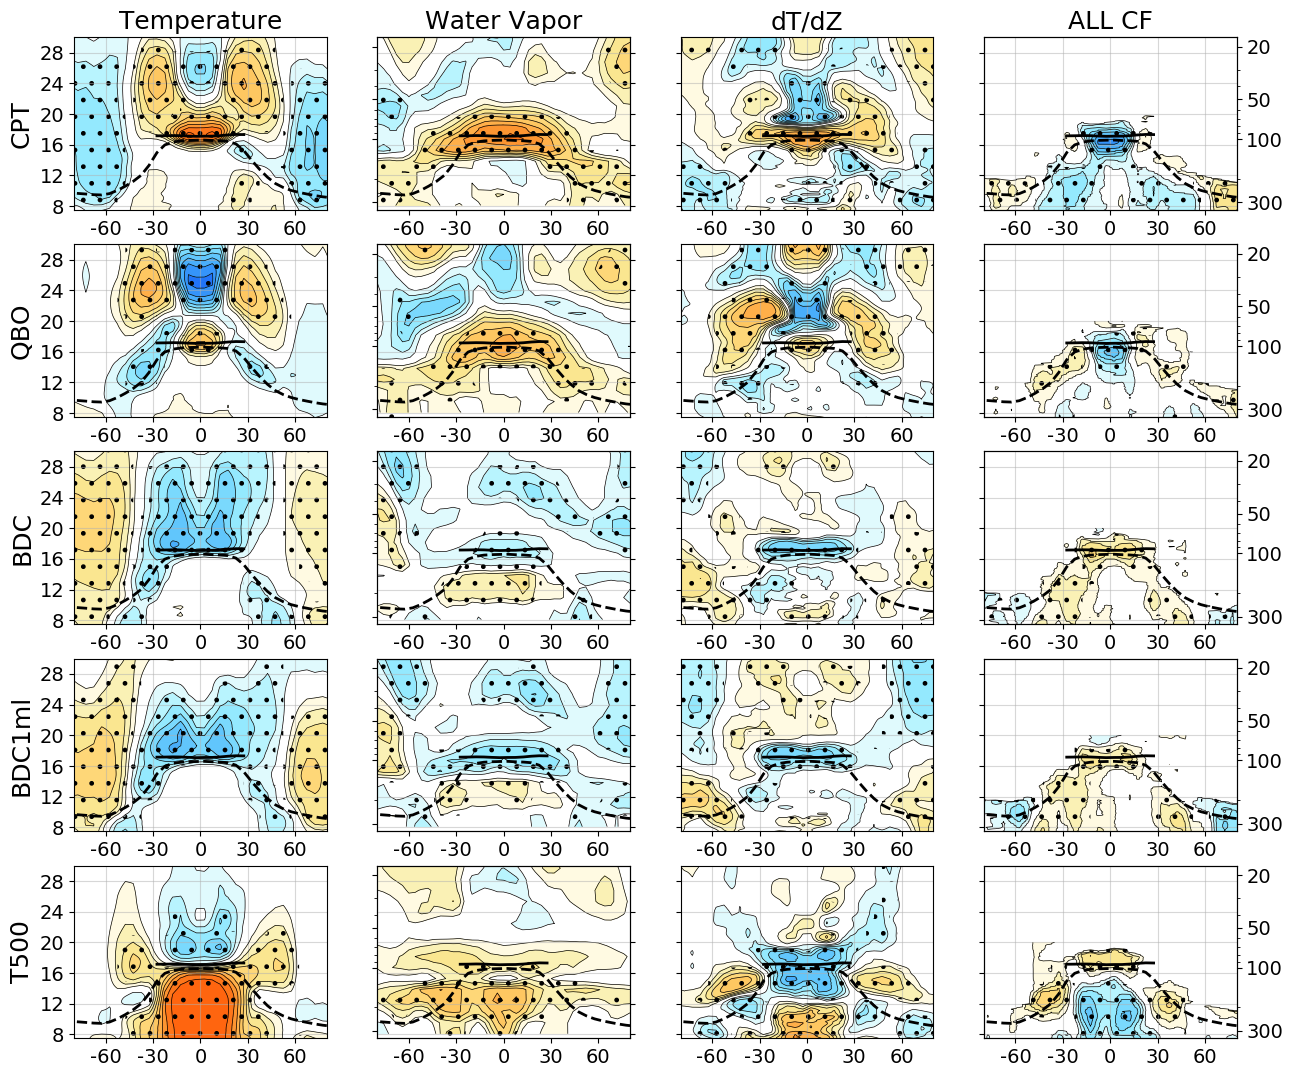

In [45]:
fig, axs = plt.subplots(5,4, figsize=(15,13))
levels = np.array([-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,.1,.2,.3,.4,.5,.6,.7,.8,.9])
pressure_levels = [1000.0, 825.4042, 681.29205, 562.3413, 464.15887, 
                 383.11868, 316.22775, 261.01572, 215.44347, 177.82794, 
                 146.77992, 121.15276, 100.0, 82.54042, 68.1292, 56.23413, 
                 46.41589, 38.311867, 31.622776, 26.101572, 21.544348, 
                 17.782795, 14.677993, 12.115276, 10.0, 8.254042, 6.8129206, 
                 5.623413, 4.6415887, 3.8311868, 3.1622777, 2.6101573, 2.1544347, 
                 1.7782794, 1.4677993, 1.2115277, 1.0, 0.68129206, 0.4641589, 
                 0.31622776, 0.21544346, 0.14677992, 0.1, 0.046415888, 0.021544347, 
                 0.01, 0.004641589, 0.0021544348, 0.001, 0.0004641589, 0.00021544346, 
                 1e-04, 4.6415887e-05, 2.1544347e-05, 1e-05]
pressures_as_alts = press2alt(np.array(pressure_levels))
alts_as_pressures = alt2pres(np.linspace(0,20, 201))
cm = custom_cmap

row_labels = ['CPT', 'QBO', 'BDC', 'BDC1ml', 'T500']
col_labels = ["Temperature", "Water Vapor", "dT/dZ", "ALL CF"]
corr_maps = np.array(
            [[cpt_temp_rmap, cpt_wv_rmap, cpt_dtdz_rmap, cpt_cf_rmap],
             [qbo_temp_rmap, qbo_wv_rmap, qbo_dtdz_rmap, qbo_cf_rmap], 
             [bdc_temp_rmap, bdc_wv_rmap, bdc_dtdz_rmap, bdc_cf_rmap],
             [bdc1ml_temp_rmap, bdc1ml_wv_rmap, bdc1ml_dtdz_rmap, bdc1ml_cf_rmap],
             [enso_temp_rmap, enso_wv_rmap, enso_dtdz_rmap, enso_cf_rmap]])
sig_maps = np.array(
            [[cpt_temp_sigmap, cpt_wv_sigmap, cpt_dtdz_sigmap, cpt_cf_sigmap],
             [qbo_temp_sigmap, qbo_wv_sigmap, qbo_dtdz_sigmap, qbo_cf_sigmap], 
             [bdc_temp_sigmap, bdc_wv_sigmap, bdc_dtdz_sigmap, bdc_cf_sigmap],
             [bdc1ml_temp_sigmap, bdc1ml_wv_sigmap, bdc1ml_dtdz_sigmap, bdc1ml_cf_sigmap],
             [enso_temp_sigmap, enso_wv_sigmap, enso_dtdz_sigmap, enso_cf_sigmap]])

for row in range(5):
    axs[row,0].set_ylabel(row_labels[row], fontsize=18)
    for col in [0,2,3]:
        if col != 3:
            axs[0,col].set_title(col_labels[col], fontsize=18)
            axs[row,col].contourf(np.linspace(-87.5,87.5,36), np.linspace(5,40,350), corr_maps[row,col], levels=levels, cmap=cm, extend='both')
            axs[row,col].contour(np.linspace(-87.5,87.5,36), np.linspace(5,40,350), corr_maps[row,col], levels=levels, colors='black', 
                                 linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
            axs[row,col].contourf(np.linspace(-87.5,87.5,36), np.linspace(5,40,350), sig_maps[row,col], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
        if col == 3:
            axs[0,col].set_title(col_labels[col], fontsize=18)
            axs[row,col].contourf(np.linspace(-87.5,87.5,36), np.linspace(0,20,201), corr_maps[row,col][:201], levels=levels, cmap=cm)
            axs[row,col].contour(np.linspace(-87.5,87.5,36), np.linspace(0,20,201), corr_maps[row,col][:201], levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
            axs[row,col].contourf(np.linspace(-87.5,87.5,36), np.linspace(0,20,201), sig_maps[row,col][:201], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
            naned_cyclic_cal = corr_maps[row,col][:201].copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[row,col].twinx()
            ax2.contourf(np.linspace(-87.5,87.5,36), alts_as_pressures, naned_cyclic_cal)
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.set_ylim(342,17)
            ax2.set_yticks([300, 100, 50, 20])
            ax2.set_yticklabels(labels=['300','100','50','20'], fontsize=14)
        
        axs[row, col].plot(np.linspace(-87.5,87.5,36), lrz_maps_zm_annual_mean, color='black', linewidth=2, linestyle='dashed')
        axs[row, col].plot(np.linspace(-87.5,87.5,36)[12:24], cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
        axs[row, col].set_ylim(7.5,30)
        axs[row, col].set_xlim(-80,80)
        axs[row, col].grid(alpha=0.5)
    for col in [1]:
        axs[0,col].set_title(col_labels[col], fontsize=18)
        axs[row,col].contourf(np.linspace(-88,88,45), pressure_levels, corr_maps[row,col], levels=levels, cmap=cm)
        axs[row,col].contour(np.linspace(-88,88,45), pressure_levels, corr_maps[row,col], levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
        axs[row,col].contourf(np.linspace(-88,88,45), pressure_levels, sig_maps[row,col], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
        axs[row,col].set_ylim(axs[row,col].get_ylim()[::-1])
        axs[row,col].set_yscale('log')
        #axs[row,col].yaxis.tick_right()
        axs[row,col].set_ylim(342,17)
        axs[row,col].set_yticks([300, 100, 50, 20])
        axs[row,col].set_yticklabels(labels=[' ',' ',' ',' '], fontsize=14)
        axs[row, col].set_xlim(-80,80)
        #axs[row, col].grid(alpha=0.5)
        naned_cyclic_cal = corr_maps[row,col].copy()
        naned_cyclic_cal[:] = np.NaN
        ax2 = axs[row,col].twinx()
        ax2.contourf(np.linspace(-88,88,45), pressures_as_alts, naned_cyclic_cal)
        #ax2.yaxis.tick_left()
        ax2.grid(alpha=0.5)
        ax2.set_ylim(7.5,30)
        ax2.plot(np.linspace(-87.5,87.5,36), lrz_maps_zm_annual_mean, color='black', linewidth=2, linestyle='dashed')
        ax2.plot(np.linspace(-87.5,87.5,36)[12:24], cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
        ax2.set_yticks([8,12,16,20,24,28])
        ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)

for col in [0,1,2,3]:
    for row in range(5):
        axs[1,col].set_xticks([-60,-30,0,30,60])
        axs[row,col].set_xticks([-60,-30,0,30,60])
        if col == 0:
            axs[row,col].set_yticks([8,12,16,20,24,28])
            axs[row,col].set_yticklabels(labels=['8','12','16','20','24','28'], fontsize=14)
            ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)
        elif col == 3:
            axs[row,col].set_yticks([8,12,16,20,24,28])
            axs[row,col].set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)
            #ax2.set_yticklabels(labels=['150','100',' ',' ','70',' ', '50'], fontsize=14)
        elif col == 1:
            ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)
        else:
            axs[row,col].set_yticks([8,12,16,20,24,28])
            axs[row,col].set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)
            ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)
        axs[row,col].set_xticklabels(labels=['-60','-30','0','30','60'], fontsize=14)
